## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import warnings
import datetime
import scipy.stats as stats
from scipy.stats import f_oneway 
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Data Preprocessing

### Load data and Redo the Processing that done in EDA

In [2]:
# Read the CSV file into a DataFrame(dfloan)
dfloan = pd.read_csv('../data/loan_data_2007_2014.csv', low_memory=False)

# Dropping unnecessary columns from the dataframe
dfloan = dfloan.drop(columns=['id', 'member_id', 'Unnamed: 0'], axis=1)

# Define a function to map loan status to 'Good Loan' or 'Bad Loan'
def map_loan_status(status):
    """
    Function to map loan status to 'Bad Loan' or 'Good Loan'.
    
    Parameters:
    status (str): The loan status to be mapped.
    
    Returns:
    str: 'Bad Loan' if the status is in the list of default statuses, 'Good Loan' otherwise.
    """
    
    # List of loan statuses that imply a default
    default_statuses = [
        'Charged Off', 
        'Late (31-120 days)', 
        'Late (16-30 days)',
        'In Grace Period',
        'Default',
        'Does not meet the credit policy. Status:Charged Off'
    ]
    
    # Return 'Bad Loan' if the status is in the list of default statuses, 'Good Loan' otherwise
    return 'Bad Loan' if status in default_statuses else 'Good Loan'

# Apply the map_loan_status function to each status in the 'loan_status' column
dfloan['loan_status'] = dfloan['loan_status'].apply(map_loan_status)

# Convert the 'issue_d' column to datetime format with 'Oct-14' style dates
dfloan['issue_d'] = pd.to_datetime(dfloan['issue_d'], format='%b-%y')

# Extract the year from the datetime object ad store it in a new column 'years'
dfloan['years'] = dfloan['issue_d'].dt.year


# Define a list of state abbreviations that belong to the West region
West = [
    'CA',  # California
    'NV',  # Nevada
    'UT',  # Utah
    'CO',  # Colorado
    'WY',  # Wyoming
    'MT',  # Montana
    'ID',  # Idaho
    'OR',  # Oregon
    'WA',  # Washington
    'AK',  # Alaska
    'HI'   # Hawaii
]

# Define a list of state abbreviations that belong to the Southwest region
Southwest = [
    'AZ',  # Arizona
    'NM',  # New Mexico
    'TX',  # Texas
    'OK'   # Oklahoma
]

# Define a list of state abbreviations that belong to the Midwest region
Midwest = [
    'ND',  # North Dakota
    'MN',  # Minnesota
    'SD',  # South Dakota
    'NE',  # Nebraska
    'KS',  # Kansas
    'MO',  # Missouri
    'IA',  # Iowa
    'WI',  # Wisconsin
    'IL',  # Illinois
    'IN',  # Indiana
    'OH',  # Ohio
    'MI'   # Michigan
]

# Define a list of state abbreviations that belong to the Southeast region
Southeast = [
    'AR',  # Arkansas
    'LA',  # Louisiana
    'MS',  # Mississippi
    'AL',  # Alabama
    'GA',  # Georgia
    'TN',  # Tennessee
    'KY',  # Kentucky
    'NC',  # North Carolina
    'SC',  # South Carolina
    'WV',  # West Virginia
    'DC',  # District of Columbia
    'VA',  # Virginia
    'DE',  # Delaware
    'FL'   # Florida
]

# Define a list of state abbreviations that belong to the Northeast region
Northeast = [
    'PA',  # Pennsylvania
    'MD',  # Maryland
    'NJ',  # New Jersey
    'NY',  # New York
    'CT',  # Connecticut
    'RI',  # Rhode Island
    'MA',  # Massachusetts
    'NH',  # New Hampshire
    'VT',  # Vermont
    'ME'   # Maine
]

def us_region(state):
    """
    Function to map US state to its corresponding region.

    Parameters:
    state (str): The US state abbreviation.

    Returns:
    str: The region where the state is located.
    """
    # Check if the state is in the West region
    if state in West:
        return 'West'
    # Check if the state is in the Southwest region
    elif state in Southwest:
        return 'Southwest'
    # Check if the state is in the Midwest region
    elif state in Midwest:
        return 'Midwest'
    # Check if the state is in the Southeast region
    elif state in Southeast:
        return 'Southeast'
    # Check if the state is in the Northeast region
    elif state in Northeast:
        return 'Northeast'
    # If the state is not in any of the defined regions, return 'Other'
    else:
        return 'Other'

# Apply the function us_region to 'addr_state' column
# This will create a new column 'region' in the dataframe dfloan
dfloan['region'] = dfloan['addr_state'].apply(us_region)

### Drop Columns with High Missing Values

In [3]:
def dropnan(data, threshold):
    """
    Function to drop columns with missing values above a certain threshold.
    
    Parameters:
    data (DataFrame): The data to be cleaned.
    threshold (float): The threshold proportion of missing values, columns above threshold which will be dropped.
    
    Returns:
    DataFrame: The cleaned data with columns dropped based on the threshold.

    Examples:
    >>> dropnan(dfloan, 0.5)
    """

    # Iterate over each column in the DataFrame
    for column in data.columns:
        
        # Calculate the proportion of missing values in the current column
        missing_values = data[column].isnull().sum() / len(data)

        # if the proportion of missing values is greatwer than the threshold
        if missing_values > threshold:
            
            # Drop the current column from the DataFrame
            data = data.drop(columns=column, axis=1)
    
    # Return the cleaned DataFrame
    return data

In [4]:
# Drop the columns with missing values above the threshold
dfloan_cleaned = dropnan(dfloan, 0.4)

print(dfloan.shape)
print(dfloan_cleaned.shape)

(466285, 74)
(466285, 52)


### Drop Uneccessary Columns

In [5]:
not_necessary_col = ['sub_grade', 'emp_title', 'pymnt_plan', 'url', 'zip_code', 'title', 'addr_state',
                     'total_acc', 'out_prncp_inv','total_pymnt_inv', 'total_rec_late_fee', 
                     'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med',
                     'application_type', 'policy_code', 'acc_now_delinq', 'years']
dfloan_cleaned1 = dfloan_cleaned.drop(columns=not_necessary_col, axis=1)

In [6]:
print(dfloan_cleaned.shape)
print(dfloan_cleaned1.shape)

(466285, 52)
(466285, 34)


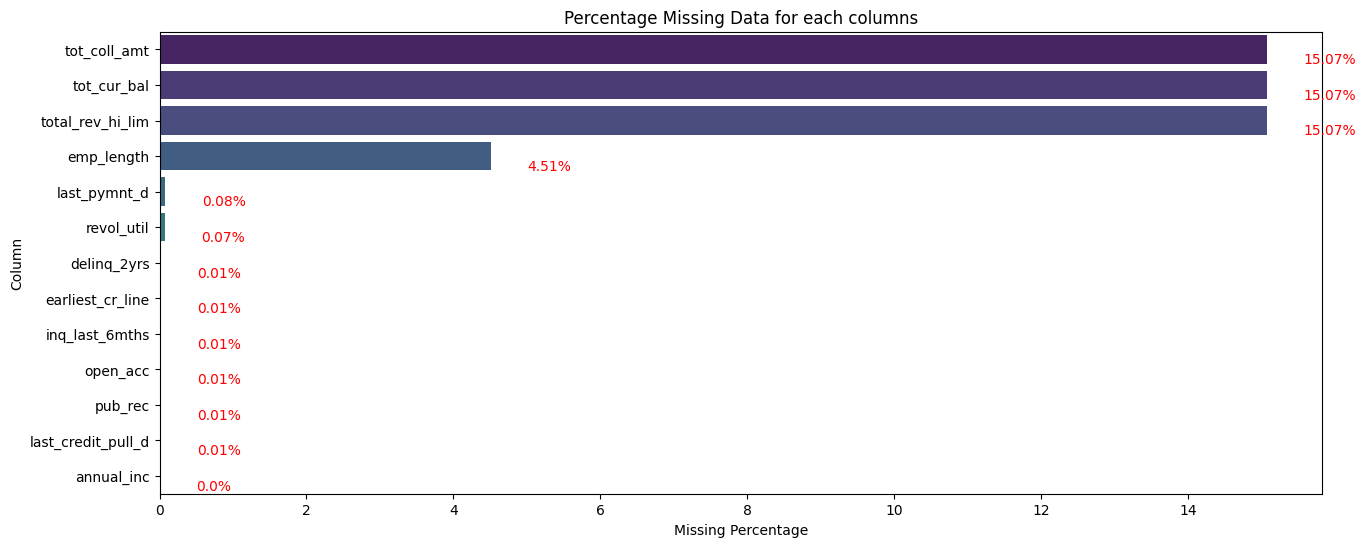

In [7]:
def plot_missing_value(data):
    # Calculate the percentage of missing values in each column
    missing = (data.isnull().sum() / len(data)) * 100
    
    # Filter out the columns that have no missing values
    missing = missing[missing>0]

    # Create a DataFrame from the missing data
    missing_data = pd.DataFrame({'Column': missing.index, 
                                 'Missing%': np.round(missing.values, 2)
    })

    # Sort the DataFrame by the percentage of missing values in descending order
    missing_data = missing_data.sort_values('Missing%', ascending=False)

    # Create a bar plot of the missing data
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x='Missing%', y='Column', data=missing_data, palette='viridis')

    # Add the percentage of missing data as text on the bars
    for i, v in enumerate(missing_data['Missing%']):
        ax.text(v + 0.5, i + .4, str(v) + '%', color='red')

    # Set the labels and title of the plot
    ax.set_xlabel('Missing Percentage')
    ax.set_title('Percentage Missing Data for each columns')

plot_missing_value(dfloan_cleaned1)


### Train Test Split

In [8]:
X = dfloan_cleaned1.drop(columns=['loan_status'])
y = dfloan_cleaned1[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1103)

print(f'X train shape: {X_train.shape}')
print(f'y train shape:{y_train.shape}')

print(f'\nX test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X train shape: (326399, 33)
y train shape:(326399, 1)

X test shape: (139886, 33)
y_test shape: (139886, 1)


### Impute rest of missing values

In [9]:
# define funtion to fill numerical missing values with median and categorical missing values with mode
def fillnan(data):
    """
    Function to fill missing values in a DataFrame. Numeric columns are filled with the median of the column,
    while categorical/non-numeric columns are filled with the mode.

    Parameters:
    data (DataFrame): The DataFrame to be cleaned.

    Returns:
    DataFrame: The cleaned DataFrame with missing values filled.

    Examples:
    >>> fillnan(data)

    """
    
    # Iterate over each column in the DataFrame
    for column in data.columns:

        # Check if the current column is numeric
        if data[column].dtype in ['int64', 'float64']:
            # Fill missing values with the median of the column
            data[column] = data[column].fillna(data[column].median())
        else:
            # Fill missing values with the mode of the column
            data[column] = data[column].fillna(data[column].mode()[0])
    # Return the cleaned DataFrame
    return data

# Fill missing values in the train set
X_train_clean = fillnan(X_train)

### Feature Selection

#### Chi Square Test for Categorical Columns

In [10]:
cat_select = X_train_clean.select_dtypes('object')

for column in cat_select.columns:
    contingency_table = pd.crosstab(X_train_clean[column], y_train['loan_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p < 0.05:
        print(f'{column} is dependent on loan_status')
    else:
        print(f'{column} is independent on loan_status')

term is dependent on loan_status
grade is dependent on loan_status
emp_length is dependent on loan_status
home_ownership is dependent on loan_status
verification_status is dependent on loan_status
purpose is dependent on loan_status
earliest_cr_line is dependent on loan_status
initial_list_status is dependent on loan_status
last_pymnt_d is dependent on loan_status
last_credit_pull_d is dependent on loan_status
region is dependent on loan_status


#### Correlation Matrix for Numerical Columns

<Axes: >

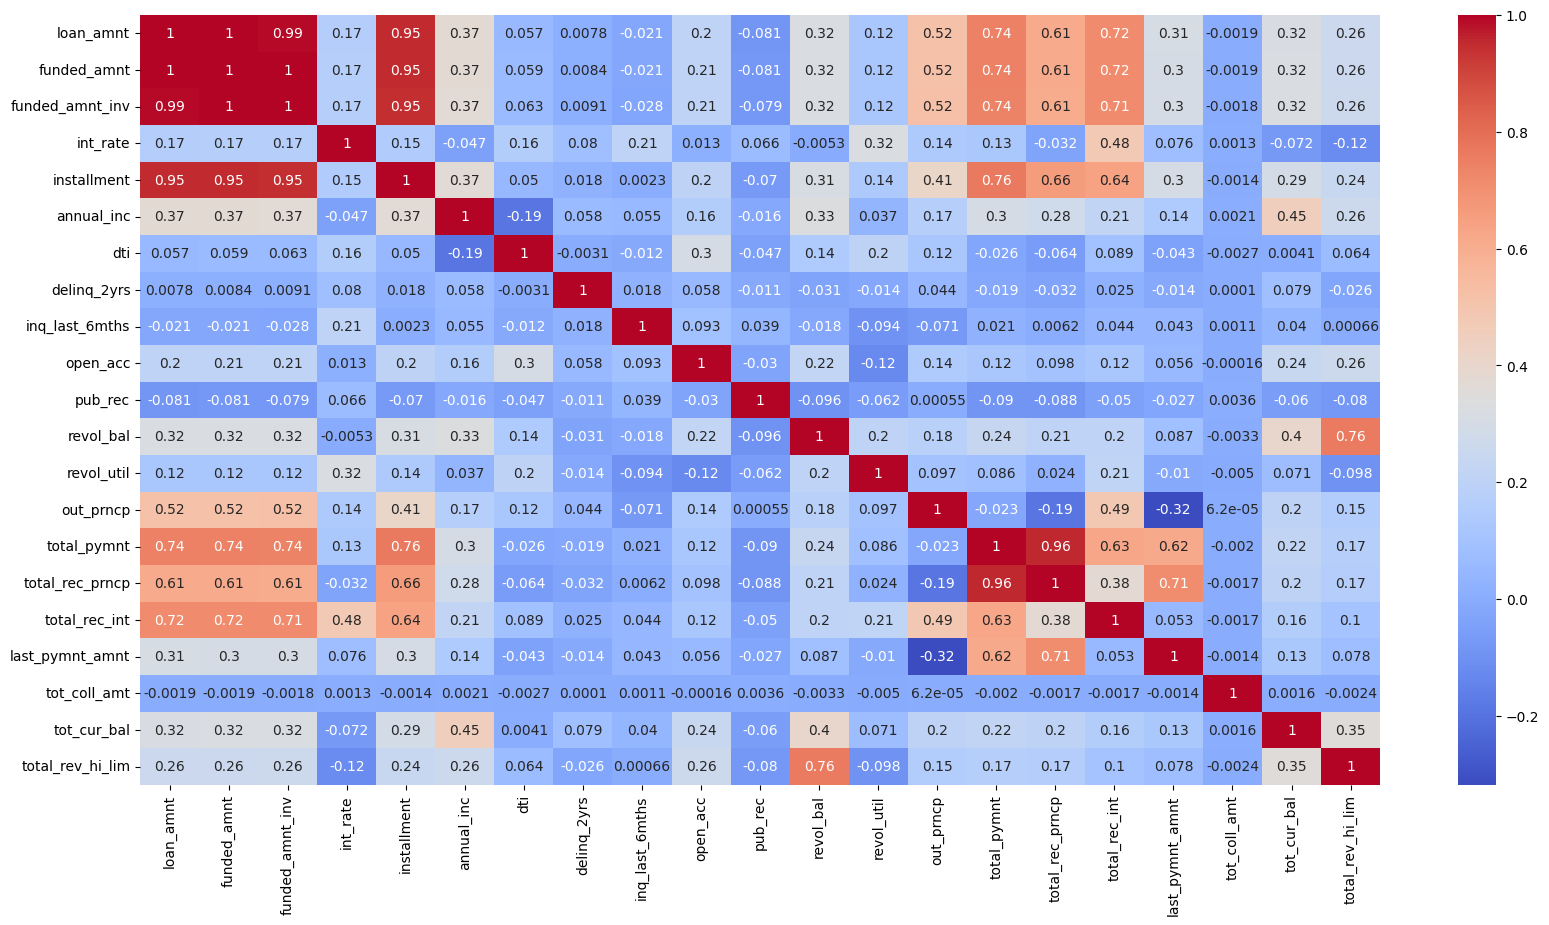

In [11]:
nums = X_train_clean.select_dtypes('number')

dfcorr = nums.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(dfcorr, cmap='coolwarm', annot=True)

In [12]:
# Drop multicollinearity columns
multi_col = ['loan_amnt', 'funded_amnt_inv', 'total_rec_int', 'total_pymnt', 'revol_bal']

X_train_nomulti = X_train_clean.drop(columns=multi_col, axis=1)

#### ANOVA Test for Numerical Columns

<Axes: xlabel='p_value', ylabel='column'>

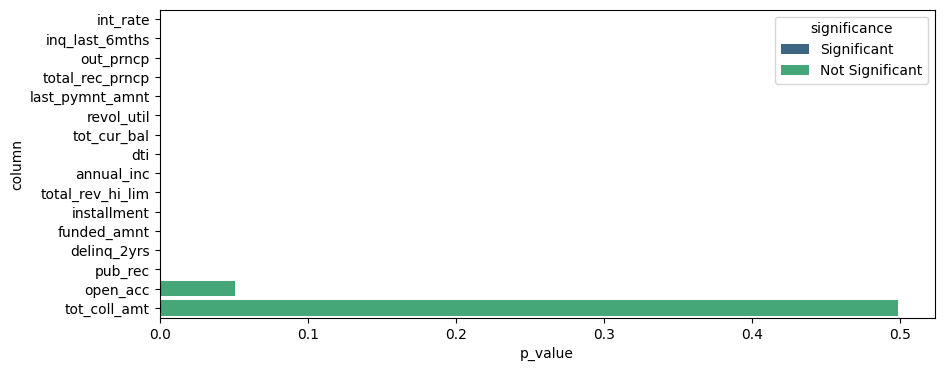

In [13]:
df_temp = pd.concat([X_train_nomulti, y_train], axis=1)
new_nums = df_temp.select_dtypes('number')

anova_results = pd.DataFrame(columns=['column', 'f_score', 'p_value', 'significance'])

# Perform ANOVA for each numerical column with respect to the target
for i, column in enumerate(new_nums.columns):
    # Separate the data based on the categories in the target
    good = df_temp[column][df_temp['loan_status'] == 'Good Loan']
    bad = df_temp[column][df_temp['loan_status'] == 'Bad Loan']
    
    # Perform the ANOVA test
    f_statistic, p_value = f_oneway(good, bad)

    # Determine the significance
    if p_value < 0.05:
        significance = 'Significant'
    else:
        significance = 'Not Significant'
    
    # Append the results to the DataFrame
    anova_results.loc[i] = [column, f_statistic, p_value, significance]

anova_results = anova_results.sort_values('p_value')

plt.figure(figsize=(10, 4))
sns.barplot(x='p_value', y='column', hue='significance', data=anova_results, palette='viridis')

`delinq_2yrs` and `tot_coll_amt` are not significant in ANOVA test, so we can drop them.

In [14]:
# Define a list of columns that are not significant for the model
not_sig = ['delinq_2yrs', 'tot_coll_amt']

# Drop the non-significant columns from the training data
X_train_selected = X_train_nomulti.drop(columns=not_sig, axis=1)

# Display a random sample of 3 rows from the modified training data
X_train_selected.sample(3)

,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,out_prncp,total_rec_prncp,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,tot_cur_bal,total_rev_hi_lim,region
449866,12000,36 months,7.90,375.49,A,10+ years,RENT,41000.0,Not Verified,2014-01-01,debt_consolidation,26.11,Nov-95,3.0,13.0,0.0,14.2,w,4663.38,7336.62,Jan-16,375.49,Jan-16,38007.0,57100.0,Midwest
84495,10625,36 months,15.61,371.51,C,1 year,OWN,32000.0,Not Verified,2013-10-01,debt_consolidation,9.27,Jun-07,0.0,5.0,0.0,93.7,w,0.00,10625.00,May-15,6024.15,Jan-16,11622.0,12400.0,Northeast
141680,3925,36 months,12.12,130.60,B,1 year,MORTGAGE,32000.0,Verified,2013-05-01,debt_consolidation,15.26,Feb-02,0.0,5.0,0.0,91.8,w,0.00,3925.00,Apr-15,1005.69,Jan-16,246414.0,13800.0,West


In [15]:
X = dfloan_cleaned1.drop(columns=['loan_status'])
y = dfloan_cleaned1[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1103)

X_train_clean = fillnan(X_train)

# Drop multicollinearity columns
multi_col = ['loan_amnt', 'funded_amnt_inv', 'total_rec_int', 'total_pymnt', 'revol_bal']

X_train_nomulti = X_train_clean.drop(columns=multi_col, axis=1)

not_sig = ['delinq_2yrs', 'tot_coll_amt']
X_train_selected = X_train_nomulti.drop(columns=not_sig, axis=1)

### Cap Outliers

In [16]:
# Define function to cap outliers
def cap_outliers(data, cols):
    """
    Function to cap outliers in a DataFrame.

    Parameters:
    data (DataFrame): The DataFrame to be cleaned.
    cols (List): The list of columns to cap outliers in.

    Returns:
    DataFrame: The cleaned DataFrame with outliers capped.

    Examples:
    >>> cap_outliers(X_train, outlier_cols)

    """

    # Iterate over each column in the DataFrame
    for column in cols:
        # Calculate the first quartile
        Q1 = data[column].quantile(0.25)
        # Calculate the third quartile
        Q3 = data[column].quantile(0.75)
        # Calculate the interquartile range
        IQR = Q3 - Q1
        # Calculate the lower bound
        lower_bound = Q1 - 1.5 * IQR
        # Calculate the upper bound
        upper_bound = Q3 + 1.5 * IQR
        # Cap the outliers
        data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
        data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

    return data

In [17]:
# Define a list of columns that have outliers
outliers = ['annual_inc', 'inq_last_6mths', 'open_acc', 'revol_util']

# Use the 'cap_outliers' function to handle outliers in the training data
# The function caps the outliers in the specified columns of the DataFrame
X_train_noutlier = cap_outliers(X_train_selected, outliers)

# Display a random sample of 3 rows from the modified training data
X_train_noutlier.sample(3)

,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,out_prncp,total_rec_prncp,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,tot_cur_bal,total_rev_hi_lim,region
195379,26000,36 months,18.49,946.37,D,8 years,MORTGAGE,68000.0,Verified,2012-10-01,debt_consolidation,9.05,Nov-04,2.0,6.0,0.0,95.5,f,0.00,26000.00,Oct-14,11261.61,Mar-15,178504.0,11600.0,Northeast
66293,7925,36 months,14.30,272.02,C,10+ years,MORTGAGE,55000.0,Verified,2013-11-01,credit_card,26.79,Mar-91,1.0,23.0,0.0,44.8,f,0.00,7925.00,Mar-15,5118.37,Mar-15,210534.0,33600.0,Southwest
349687,20000,60 months,16.29,489.45,D,3 years,MORTGAGE,58240.0,Source Verified,2014-07-01,debt_consolidation,18.59,Oct-79,0.0,17.0,0.0,45.1,f,15865.38,4134.62,Jan-16,489.45,Jan-16,25935.0,31000.0,Southwest


### Further Feature Engineering

#### Feature Creation

In [24]:
# Create a copy of the selected features for further feature engineering
X_train_eng = X_train_noutlier.copy()

# Define a function to convert a date column into two new columns
def days_month_converter(data, date_col):
    """
    This function converts a date column into two new columns:
    1. days_since_{date_col}: Number of days from the date to the current date.
    2. {date_col}_month: The month of the date.

    Parameters:
    data (DataFrame): The DataFrame containing the date column.
    date_col (str): The name of the date column to convert.

    Returns:
    DataFrame: The updated DataFrame with the new columns and the original date column dropped.

    Examples:
    >>> days_month_converter(dfloan_cleaned, 'issue_d')
    """

    # Convert the date column to datetime format
    data[date_col] = pd.to_datetime(data[date_col], format='%b-%y')

    # Get the current date
    current_date = datetime.datetime.now()

    # Create a new column for the number of days from the date to the current date
    data[f"days_since_{date_col}"] = (current_date - data[date_col]).dt.days

    # Create a new column for the month of the date
    data[f"{date_col}_month"] = data[date_col].dt.month

    # Drop the original date column
    data = data.drop(columns=date_col, axis=1)

    return data

# List of date columns to convert
dates = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']

# Convert the date columns in the list to days and month columns
for date in dates:
   X_train_eng = days_month_converter(X_train_eng, date)


# For 'pub_rec' column, if the value is greater than 0, replace it with 'no', otherwise replace it with 'yes'
X_train_eng['pub_rec'] = X_train_eng['pub_rec'].apply(lambda x: 'no' if x > 0 else 'yes')

# Create a mapping for 'initial_list_status' column
map_istatus = {
    'f': 'fractional',
    'w': 'whole'
}

# Apply the mapping to 'initial_list_status' column
X_train_eng['initial_list_status'] = X_train_eng['initial_list_status'].map(map_istatus)

# Create a mapping for 'home_ownership' column
map_home = {
    'NONE': 'OTHER'  # Map 'NONE' to 'OTHER'
}

# Apply the mapping to 'home_ownership' column
X_train_eng['home_ownership'] = X_train_eng['home_ownership'].replace(map_home)

# Display a random sample of 3 rows from the modified training data
X_train_eng.sample(3)

,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,out_prncp,total_rec_prncp,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,region,days_since_earliest_cr_line,earliest_cr_line_month,days_since_issue_d,issue_d_month,days_since_last_pymnt_d,last_pymnt_d_month,days_since_last_credit_pull_d,last_credit_pull_d_month
21227,5000,60 months,13.72,115.62,C,8 years,RENT,36000.0,Not Verified,medical,5.17,1.0,12.0,yes,23.2,fractional,0.0,1369.99,115.62,81504.0,22800.0,Southeast,7519,9,4840,1,4170,11,4050,3
378476,1000,36 months,14.99,34.67,C,10+ years,MORTGAGE,58700.0,Source Verified,vacation,20.84,2.0,12.0,no,38.4,whole,0.0,1000.00,897.37,191121.0,20500.0,Southeast,8676,7,3593,6,3410,12,3379,1
55233,30000,36 months,15.61,1048.95,C,8 years,OWN,68000.0,Verified,debt_consolidation,6.30,2.5,10.0,yes,36.7,fractional,0.0,30000.00,26966.10,59706.0,44400.0,Midwest,8402,4,3775,12,3593,6,3014,1


#### Feature Encoding

In [25]:
# create a copy of X_train
X_train_enc = X_train_eng.copy()

# List of columns to be one-hot encoded
col_to_ohe = X_train_enc.select_dtypes('object').columns

# Perform one-hot encoding on each column in the list
for column in col_to_ohe:
    # Create dummy variables for each unique category in the column
    dummies = pd.get_dummies(X_train_enc[column], prefix=f'{column}:').astype(int)
    
    # Concatenate the dummy variables with the original DataFrame
    X_train_enc = pd.concat([X_train_enc, dummies], axis=1)
    
    # Drop the original column from the DataFrame
    X_train_enc.drop(columns=column, axis=1, inplace=True)


# Define a mapping for 'loan_status' column values
map_target = {
    'Good Loan': 0,  # Map 'Good Loan' to 0
    'Bad Loan': 1    # Map 'Bad Loan' to 1
}

# Apply the mapping to the target train and test
y_train['loan_status'] = y_train['loan_status'].map(map_target)

# Display encoded training data shape, a random sample of 3 rows and target
print(X_train_enc.shape)
display(X_train_enc.sample(3))
display(y_train.sample(3))

(326399, 71)


,funded_amnt,int_rate,installment,annual_inc,dti,inq_last_6mths,open_acc,revol_util,out_prncp,total_rec_prncp,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,days_since_earliest_cr_line,earliest_cr_line_month,days_since_issue_d,issue_d_month,days_since_last_pymnt_d,last_pymnt_d_month,days_since_last_credit_pull_d,last_credit_pull_d_month,term:_ 36 months,term:_ 60 months,grade:_A,grade:_B,grade:_C,grade:_D,grade:_E,grade:_F,grade:_G,emp_length:_1 year,emp_length:_10+ years,emp_length:_2 years,emp_length:_3 years,emp_length:_4 years,emp_length:_5 years,emp_length:_6 years,emp_length:_7 years,emp_length:_8 years,emp_length:_9 years,emp_length:_< 1 year,home_ownership:_MORTGAGE,home_ownership:_OTHER,home_ownership:_OWN,home_ownership:_RENT,verification_status:_Not Verified,verification_status:_Source Verified,verification_status:_Verified,purpose:_car,purpose:_credit_card,purpose:_debt_consolidation,purpose:_educational,purpose:_home_improvement,purpose:_house,purpose:_major_purchase,purpose:_medical,purpose:_moving,purpose:_other,purpose:_renewable_energy,purpose:_small_business,purpose:_vacation,purpose:_wedding,pub_rec:_no,pub_rec:_yes,initial_list_status:_fractional,initial_list_status:_whole,region:_Midwest,region:_Northeast,region:_Southeast,region:_Southwest,region:_West
350508,24000,16.99,596.34,150000.0,25.15,0.0,23.0,59.7,18782.27,5217.73,596.34,620853.0,107000.0,7458,11,3563,7,3014,1,3014,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
243436,7450,12.39,248.84,35000.0,33.09,1.0,8.0,52.1,5071.22,2378.78,248.84,40853.0,5500.0,-12327,1,3440,11,3045,12,3014,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
283640,9600,14.99,332.75,65000.0,29.47,1.0,6.0,43.0,6112.70,3487.30,332.75,80933.0,6250.0,10259,3,3471,10,3014,1,3014,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0


,loan_status
401553,1
381982,0
232290,0


### Feature Scaling

In [26]:
# Select numerical columns from the DataFrame, excluding 'pub_rec'
num_scale = X_train_eng.select_dtypes('number')

# Initialize a StandardScaler
scaler = StandardScaler()

# Scale the numerical columns and convert the result into a DataFrame
X_scale = pd.DataFrame(scaler.fit_transform(num_scale))

# Assign the original column names to the scaled DataFrame
X_scale.columns = num_scale.columns

# Drop the numerical columns from the encoded DataFrame
X_train_catenc = X_train_enc.drop(columns=num_scale.columns)

# Make sure the indices of the encoded DataFrame match with the original DataFrame
X_train_catenc.index = X_train_selected.index
X_scale.index = X_train_selected.index

# Concatenate the scaled numerical DataFrame and the encoded categorical DataFrame
X_train_scaled = pd.concat([X_scale, X_train_catenc], axis=1)

# Display scaled training data shape and a random sample of 3 rows
print(X_train_scaled.shape)
display(X_train_scaled.sample(3))

(326399, 71)


,funded_amnt,int_rate,installment,annual_inc,dti,inq_last_6mths,open_acc,revol_util,out_prncp,total_rec_prncp,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,days_since_earliest_cr_line,earliest_cr_line_month,days_since_issue_d,issue_d_month,days_since_last_pymnt_d,last_pymnt_d_month,days_since_last_credit_pull_d,last_credit_pull_d_month,term:_ 36 months,term:_ 60 months,grade:_A,grade:_B,grade:_C,grade:_D,grade:_E,grade:_F,grade:_G,emp_length:_1 year,emp_length:_10+ years,emp_length:_2 years,emp_length:_3 years,emp_length:_4 years,emp_length:_5 years,emp_length:_6 years,emp_length:_7 years,emp_length:_8 years,emp_length:_9 years,emp_length:_< 1 year,home_ownership:_MORTGAGE,home_ownership:_OTHER,home_ownership:_OWN,home_ownership:_RENT,verification_status:_Not Verified,verification_status:_Source Verified,verification_status:_Verified,purpose:_car,purpose:_credit_card,purpose:_debt_consolidation,purpose:_educational,purpose:_home_improvement,purpose:_house,purpose:_major_purchase,purpose:_medical,purpose:_moving,purpose:_other,purpose:_renewable_energy,purpose:_small_business,purpose:_vacation,purpose:_wedding,pub_rec:_no,pub_rec:_yes,initial_list_status:_fractional,initial_list_status:_whole,region:_Midwest,region:_Northeast,region:_Southeast,region:_Southwest,region:_West
176518,-0.27726,-0.392469,-0.135298,0.138692,-1.271743,-0.839672,-1.310212,1.352102,-0.693814,0.444015,0.804576,0.770674,-0.599137,-0.783225,-1.381283,0.536636,-1.834463,0.915303,-0.045108,-0.314331,2.626305,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
189500,0.44757,-0.165300,0.719305,0.138692,-1.357055,-0.839672,-0.880075,-0.741519,-0.693814,1.296387,-0.453827,-0.766546,-0.195202,0.549337,0.649787,0.747173,0.879240,-0.491153,1.325542,-0.106785,2.049754,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
324882,0.68918,-0.651762,0.913181,1.173977,0.345353,2.059342,0.410339,0.685182,1.095138,-0.034621,-0.445288,1.997298,-0.049785,-0.036570,-0.800977,-0.783796,0.276195,-0.647426,-0.958874,-0.419805,-0.544727,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


### Resample Data

In [27]:
smot = SMOTE(random_state=1103)

X_train_ovr, y_train_ovr = smot.fit_resample(X_train_scaled, y_train)

print(f"Target before Resampled:\n{y_train.value_counts()}")
print(f"\nTarget after Resampled:\n{y_train_ovr.value_counts()}")

Target before Resampled:
loan_status
0              289916
1               36483
Name: count, dtype: int64

Target after Resampled:
loan_status
0              289916
1              289916
Name: count, dtype: int64


### Update all the processing to data Test
(Handle missing values & Feature encoding only)

In [28]:
X_test_clean = fillnan(X_test)

X_test_nomulti = X_test_clean.drop(columns=multi_col, axis=1)

X_test_selected = X_test_nomulti.drop(columns=not_sig, axis=1)

X_test_eng = X_test_selected.copy()

# Convert the date columns in the list to days and month columns
for date in dates:
   X_test_eng = days_month_converter(X_test_eng, date)

X_test_eng['pub_rec'] = X_test_eng['pub_rec'].apply(lambda x: 'no' if x == 0 else 'yes')

X_test_eng['initial_list_status'] = X_test_eng['initial_list_status'].map(map_istatus)

map_home = {
    'NONE': 'OTHER',  # Map 'NONE' to 'OTHER'
    'ANY': 'OTHER' # Map 'ANY' to 'OTHER'
}

# Apply the mapping to the 'home_ownership' column
X_test_eng['home_ownership'] = X_test_eng['home_ownership'].replace(map_home)

# create a copy of X_train
X_test_enc = X_test_eng.copy()

# List of columns to be one-hot encoded
col_to_ohe = X_test_enc.select_dtypes('object').columns

# Perform one-hot encoding on each column in the list
for column in col_to_ohe:
    # Create dummy variables for each unique category in the column
    dummies = pd.get_dummies(X_test_enc[column], prefix=f'{column}:').astype(int)
    
    # Concatenate the dummy variables with the original DataFrame
    X_test_enc = pd.concat([X_test_enc, dummies], axis=1)
    
    # Drop the original column from the DataFrame
    X_test_enc.drop(columns=column, axis=1, inplace=True)

# Apply the mapping to the target train and test
y_test['loan_status'] = y_test['loan_status'].map(map_target)

# Display a random sample of 3 rows from the preprocessed test data and target
print(X_test_enc.shape)
display(X_test_enc.sample(3))
display(y_test.sample(3))

(139886, 71)


,funded_amnt,int_rate,installment,annual_inc,dti,inq_last_6mths,open_acc,revol_util,out_prncp,total_rec_prncp,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,days_since_earliest_cr_line,earliest_cr_line_month,days_since_issue_d,issue_d_month,days_since_last_pymnt_d,last_pymnt_d_month,days_since_last_credit_pull_d,last_credit_pull_d_month,term:_ 36 months,term:_ 60 months,grade:_A,grade:_B,grade:_C,grade:_D,grade:_E,grade:_F,grade:_G,emp_length:_1 year,emp_length:_10+ years,emp_length:_2 years,emp_length:_3 years,emp_length:_4 years,emp_length:_5 years,emp_length:_6 years,emp_length:_7 years,emp_length:_8 years,emp_length:_9 years,emp_length:_< 1 year,home_ownership:_MORTGAGE,home_ownership:_OTHER,home_ownership:_OWN,home_ownership:_RENT,verification_status:_Not Verified,verification_status:_Source Verified,verification_status:_Verified,purpose:_car,purpose:_credit_card,purpose:_debt_consolidation,purpose:_educational,purpose:_home_improvement,purpose:_house,purpose:_major_purchase,purpose:_medical,purpose:_moving,purpose:_other,purpose:_renewable_energy,purpose:_small_business,purpose:_vacation,purpose:_wedding,pub_rec:_no,pub_rec:_yes,initial_list_status:_fractional,initial_list_status:_whole,region:_Midwest,region:_Northeast,region:_Southeast,region:_Southwest,region:_West
417657,31500,12.99,716.57,140000.0,15.04,0.0,10.0,77.5,22697.48,8802.52,716.57,286772.0,60900.0,11294,5,3654,4,3014,1,3014,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
273805,28000,10.99,608.65,115000.0,6.31,0.0,8.0,2.7,0.00,28000.00,27764.30,603160.0,60900.0,8706,6,3471,10,3379,1,3348,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
403783,5000,10.99,163.67,30000.0,17.88,0.0,10.0,33.0,2425.59,2574.41,163.67,121946.0,9600.0,6301,1,3654,4,3014,1,3014,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0


,loan_status
252391,0
294520,0
236554,0


### Update all the processing to the original data (X and y) for cross validation
(Handle missing values & Feature encoding only)

In [29]:
X_clean = fillnan(X)

X_nomulti = X_clean.drop(columns=multi_col, axis=1)

X_selected = X_nomulti.drop(columns=not_sig, axis=1)

X_eng = X_selected.copy()

# Convert the date columns in the list to days and month columns
for date in dates:
   X_eng = days_month_converter(X_eng, date)

X_eng['pub_rec'] = X_eng['pub_rec'].apply(lambda x: 'no' if x == 0 else 'yes')

X_eng['initial_list_status'] = X_eng['initial_list_status'].map(map_istatus)

map_home = {
    'NONE': 'OTHER',  # Map 'NONE' to 'OTHER'
    'ANY': 'OTHER' # Map 'ANY' to 'OTHER'
}

# Apply the mapping to the 'home_ownership' column
X_eng['home_ownership'] = X_eng['home_ownership'].replace(map_home)

# create a copy of X
X_enc = X_eng.copy()

# List of columns to be one-hot encoded
col_to_ohe = X_enc.select_dtypes('object').columns

# Perform one-hot encoding on each column in the list
for column in col_to_ohe:
    # Create dummy variables for each unique category in the column
    dummies = pd.get_dummies(X_enc[column], prefix=f'{column}:').astype(int)
    
    # Concatenate the dummy variables with the original DataFrame
    X_enc = pd.concat([X_enc, dummies], axis=1)
    
    # Drop the original column from the DataFrame
    X_enc.drop(columns=column, axis=1, inplace=True)

# Assuming y is your target variable for the new dataset
# Apply the mapping to the target
y['loan_status'] = y['loan_status'].map(map_target)

### Modeling Logistic Regression
Because in this Final Task Logistic Regression is the main focus, so I will use Logistic Regression as the main model.

#### Define function to Evaluate Model

In [30]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold):
    """
    This function evaluates the performance of a given model using various metrics.
    
    Parameters:
    model: The machine learning model to be evaluated.
    X_train: The training data.
    y_train: The labels for the training data.
    X_test: The testing data.
    y_test: The labels for the testing data.
    threshold: The threshold for classifying the output into different classes.
    
    Returns:
    Displays a DataFrame with the evaluation metrics for the model.

    Examples:
    >>> evaluate_model(LogisticRegression(), X_train, y_train, X_test, y_test, 0.5)
    """
    
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the labels for the training and testing data
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Predict the probabilities of the positive class for the training and testing data
    train_pred_proba = model.predict_proba(X_train)[:, 1]  
    test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute the ROC AUC scores for the training and testing data
    train_auc = roc_auc_score(y_train, train_pred_proba)
    test_auc = roc_auc_score(y_test, test_pred_proba)

    # Compute the recall scores for the training and testing data
    train_recall = recall_score(y_train, train_pred_proba > threshold)
    test_recall = recall_score(y_test, test_pred_proba > threshold)

    # Compute the precision scores for the training and testing data
    train_precision = precision_score(y_train, train_pred_proba > threshold)
    test_precision = precision_score(y_test, test_pred_proba > threshold)

    # Compute the F1 scores for the training and testing data
    train_f1 = f1_score(y_train, train_pred_proba > threshold)
    test_f1 = f1_score(y_test, test_pred_proba > threshold)

    # Perform Stratified K-Fold Cross Validation and compute the ROC AUC score
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1103)
    cv_score = cross_val_score(model, X_enc, y, cv=skf, scoring='roc_auc')

    # Create a dictionary with the evaluation metrics
    scoredict = {
        'Model': 'LogisticRegression', 
        'AUC_train': [train_auc], 
        'AUC_test': [test_auc],
        'Recall_train': [train_recall],
        'Recall_test': [test_recall],
        'Precision_train': [train_precision],
        'Precision_test': [test_precision],
        'F1_train': [train_f1], 
        'F1_test': [test_f1],
        'CrossVal_AUC': [cv_score.mean()]
    }

    # Convert the dictionary to a DataFrame
    df_eval = pd.DataFrame(scoredict)
    
    # Display the DataFrame
    display(df_eval)

In [31]:
def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    """
    This function plots the Receriver Operating Characteristic (ROC) curve for a given model.

    Parameters:
    model: The machine learning model to be evaluated.
    X_train: The training data.
    y_train: The labels for the training data.
    X_test: The testing data.
    y_test: The labels for the testing data.

    Returns:
    A plot of the ROC curve, with the area under the curve (AUC) displayed in the legend.

    Examples:
    >>> plot_orc_curve(LogisticRegression(), X_train, y_train, X_test, y_test)

    """

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the probabilities of the positive calss for the testing data
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute the false positive rate,  true positive rate, and thresholds for the ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Compute the area under the ROC curve
    auc = roc_auc_score(y_test, y_pred_proba)

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')

    # Plot the line of no discrimination
    plt.plot([0, 1], [0, 1], 'r--')

    # Label the x-axis as 'False Positive Rate'
    plt.xlabel('False Positive Rate')

    # Label the y-axis as 'True Positive Rate'
    plt.ylabel('True Positive Rate')

    # Title the plot as 'ROC Curve'
    plt.title('ROC Curve')

    # Display the legend
    plt.legend()

    # Display the plot
    plt.show()

#### Train and Evaluate Model 

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,LogisticRegression,0.997336,0.766714,0.972326,0.973381,0.999153,0.218105,0.985557,0.35636,0.955349


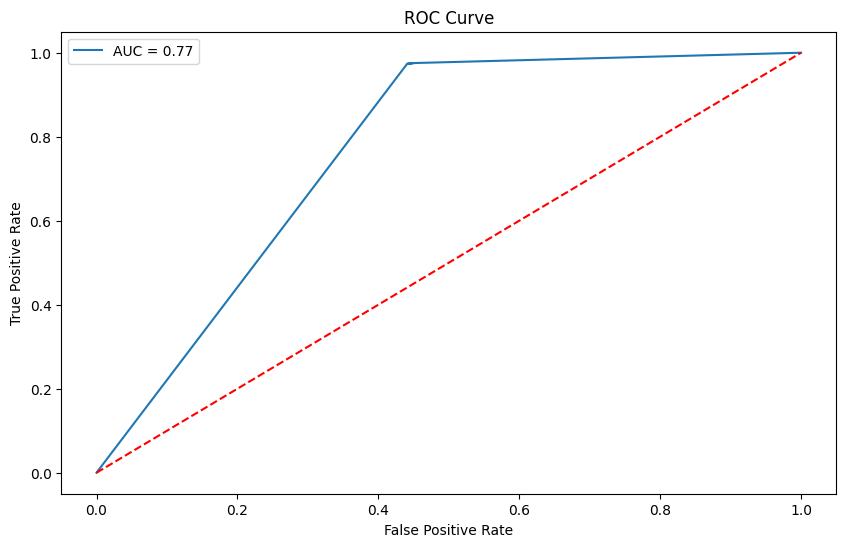

In [32]:
# Instantiate a Logistic Regression model with a specified random state for reproducibility
lr = LogisticRegression(random_state=1103)

# Evaluate the Logistic Regression model using the over-sampled training data, testing data, and a threshold of 0.5
evaluate_model(lr, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.5)

# Plot the ROC curve for the Logistic Regression model using the over-sampled training data and testing data
plot_roc_curve(lr, X_train_ovr, y_train_ovr, X_test_enc, y_test)

- seems like our model is overfitting, as we can see that the f1 test score is lower than f1 train score.<br> Let's try to tune the model using hyperparameter tuning.
- From the ROC curve we can see that the model good enough, but we can try to improve it by tuning the model.

### Logistic Regression Hyperparameter Tuning

In [32]:
# Define parameters to tune the model
param_grid = {
    'C': np.linspace(0.001, 1, 100),
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cholesky', 'saga', 'sag']
}

# Initialize the GridSearchCV object with 5-fold cross-validation
ranscv = RandomizedSearchCV(lr, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the GridSearchCV object to the data
ranscv.fit(X_train_ovr, y_train_ovr)

# Get the best parameters and the best score
best_params = ranscv.best_params_
best_score = ranscv.best_score_

# Display the best parameters and the best score
print('Best Parameters:', best_params)
print('Best Score:', best_score)

In [35]:
# Display the best parameters and the best score
print('Best Parameters:', best_params)
print('Best Score:', best_score)

Best Parameters: {'solver': 'newton-cholesky', 'penalty': 'l2', 'C': 0.4248181818181818}
Best Score: 0.9964153923983352


In [34]:
# Instantiate a Logistic Regression model with the best parameters found from hyperparameter tuning
lrn = LogisticRegression(**best_params, random_state=1103)

# Evaluate the Logistic Regression model
evaluate_model(lrn, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.5)

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,LogisticRegression,0.997297,0.803016,0.971368,0.946189,0.999202,0.258535,0.985088,0.406106,0.955207


after parameter tuning with RandomizedSearchCV, the model performance just a little bit better than the previous model.<br>
let's try to manual tuning the model.

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,LogisticRegression,0.996587,0.862138,0.967149,0.718525,0.994439,0.998849,0.980604,0.835809,0.955508


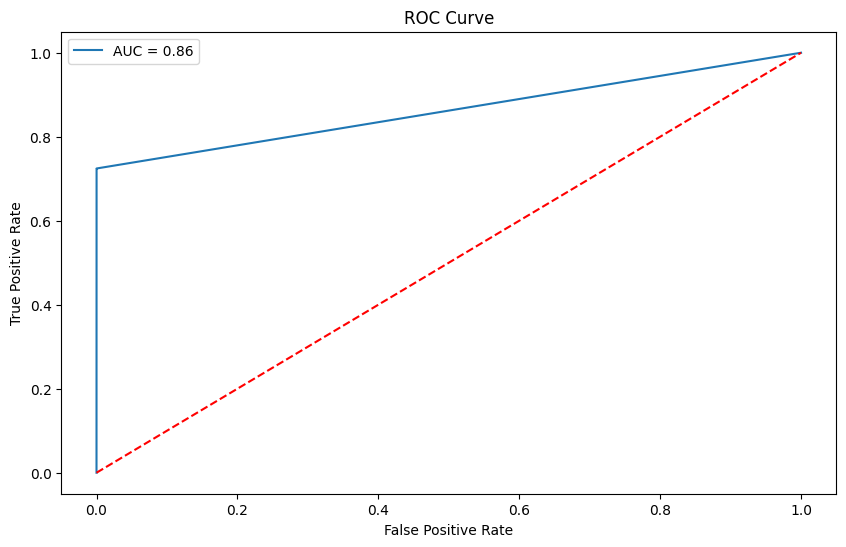

In [28]:
# Define a dictionary with the hyperparameters for the Logistic Regression model
param_dict = {
    'C': 0.01, # smaller values specify stronger regularization
    'penalty': 'l2', 
    'random_state': 1103
} 

# Instantiate a Logistic Regression model with the specified hyperparameters
lr_tuned = LogisticRegression(**param_dict)

# Evaluate the Logistic Regression model using the over-sampled training data, testing data, and a threshold of 0.4
# The threshold of 0.4 is used to balance recall and precision
evaluate_model(lr_tuned, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.4)

# Plot the ROC curve for the tuned Logistic Regression model
plot_roc_curve(lr_tuned, X_train_ovr, y_train_ovr, X_test_enc, y_test)

Seems like the precision test is too high, let's try to tune the model again(especially the C parameter).

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,LogisticRegression,0.997046,0.89972,0.970153,0.804114,0.997344,0.913279,0.983561,0.855227,0.955249


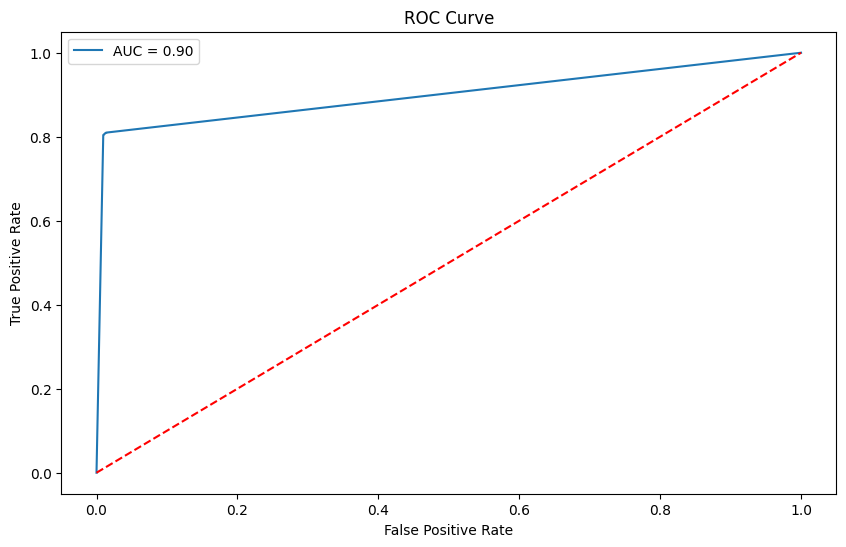

In [29]:
# Define a dictionary with the hyperparameters for the Logistic Regression model
param_dict = {
    'C': 0.05, # tune up the reguralization value
    'penalty': 'l2',
    'random_state': 1103
} # The solver is not specified as the default solver is sufficient for this case

# Instantiate a Logistic Regression model with the specified hyperparameters
lr_tuned2 = LogisticRegression(**param_dict)

# Evaluate the Logistic Regression model
evaluate_model(lr_tuned2, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.4)

# plot the ROC curve for the tuned Logistic Regression model
plot_roc_curve(lr_tuned2, X_train_ovr, y_train_ovr, X_test_enc, y_test)

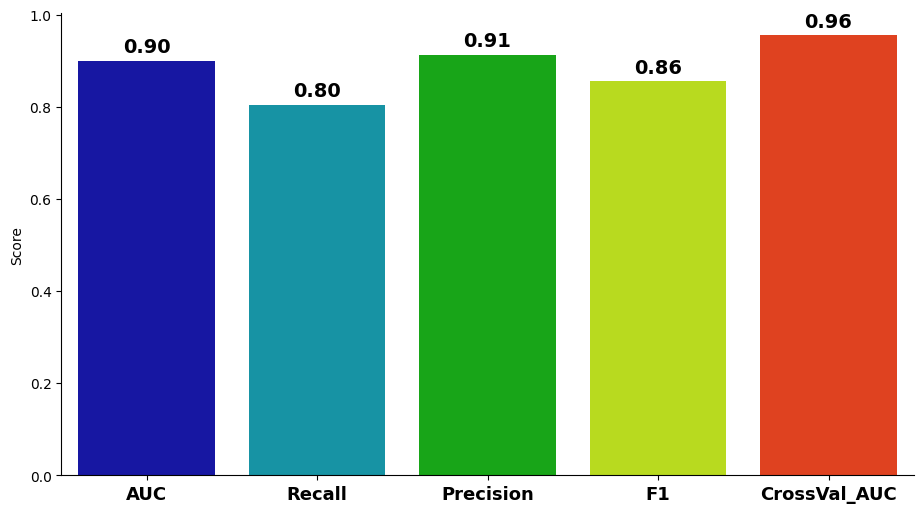

In [25]:
dictmod = {
    'AUC': [0.89972],
    'Recall': [0.804114],
    'Precision': [0.913279],
    'F1': [0.855227],
    'CrossVal_AUC': [0.955249]
}
dfmodel = pd.DataFrame(dictmod)

plt.figure(figsize=(11, 6))
barplot = sns.barplot(data=dfmodel, palette='nipy_spectral')
sns.despine()
# plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
# plt.xticks(rotation=45)

# Adding annotations
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', 
                     va = 'center', 
                     xytext = (0, 10), 
                     textcoords = 'offset points', 
                     fontsize=14, 
                     fontweight='bold')
    
plt.xticks(fontsize=13, fontweight='bold')

plt.show()

that's better, now this lr_tuned2 is my final Logistic Regression model... Let's take a look at the feature importance and the confusion matrix.

### Tuned Logistic Regression Confusion Matrix & Feature Importance

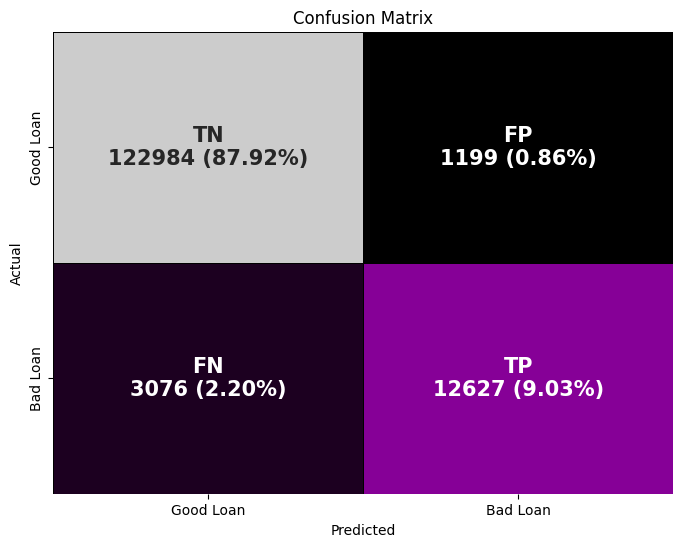

In [30]:
def plot_confusion_matrix(model, X_test, y_test, threshold):
    """
    This function plots the confusion matrix for a given model.
    
    Parameters:
    model: The machine learning model to be evaluated.
    X_test: The testing data.
    y_test: The labels for the testing data.
    threshold: The threshold for classifying the output into different classes.
    
    Returns:
    A plot of the confusion matrix, with the number and percentage of each type of prediction displayed.
    """
    
    # Get the predicted probabilities on the test data
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate the predicted values based on the threshold
    y_pred = (y_pred_proba > threshold)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate the percentage of each value in the confusion matrix
    cm_perc = cm / cm.sum()

    # Define the labels
    labels = np.array([['TN', 'FP'],
                       ['FN', 'TP']])
    
    # Create labels with the percentage values
    labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
                              for label, value, percentage in zip(labels.flatten(), cm.flatten(), cm_perc.flatten())])
                 ).reshape(2,2)

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=labels, 
        fmt='', 
        cmap='nipy_spectral', 
        cbar=False, 
        annot_kws={'size': 15, 'weight': 'bold'}, 
        linewidths=0.5, 
        linecolor='black', 
        xticklabels=['Good Loan', 'Bad Loan'], 
        yticklabels=['Good Loan', 'Bad Loan']
    
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix for the Logistic Regression model using the testing data and a threshold of 0.4
plot_confusion_matrix(lr_tuned2, X_test_enc, y_test, 0.4)

In [6]:
# Define the initial variables
tp = 12627  # true positives
fn = 3076 # false negatives
total_clients = 466285
total_clients_test = 139886
total_bad_loans_before = 52186
total_loan = 760916150 + 5903136300 # Aggregated bad loan + bad loan
avg_loan =  round(total_loan / total_clients, 2) # average loan


# Calculate the default rate before the model
dr_before_model = total_bad_loans_before / total_clients
print(f'Total bad loans before model: {total_bad_loans_before}')
print(f'\nDefault rate before model: {dr_before_model}%')

# Calculate the default rate after the model
dr_after_model = ((0.5 * tp) + fn) / total_clients_test
print(f'Default rate after model: {round(dr_after_model * 100, 1)}%')

# Calculate the decrease in default rate
decreased_dr = dr_after_model - dr_before_model
print(f'Decreased default rate: {round(decreased_dr * 100, 1)}%')

# Calculate the total bad loans after the model
total_bad_loans_after = dr_after_model * total_clients
print(f'\nTotal bad loans after model: {round(total_bad_loans_after)}')

# Calculate the decrease in bad loans
decreased_bad_loans = total_bad_loans_after - total_bad_loans_before
print(f'Decreased bad loans: {round(decreased_bad_loans)}')

# Calculate the total good clients before the model
total_good_clients_before = total_clients - total_bad_loans_before

# Calculate the total revenue, bad debt and net revenue before the model
tr_before = total_good_clients_before * avg_loan
total_bad_debt_before = total_bad_loans_before * avg_loan
net_revenue_before = tr_before - total_bad_debt_before
print('\nTotal Revenue before model:', round(tr_before))
print(f'Total bad debt before model: {round(total_bad_debt_before)}')
print(f'Net revenue before model: {round(net_revenue_before)}')

# Calculate the total good clients after the model
total_good_clients_after = total_clients - total_bad_loans_after

# Calculate the total revenue, bad debt and net revenue after the model
total_bad_debt_after = total_bad_loans_after * avg_loan
tr_after = total_good_clients_after * avg_loan
net_revenue_after = tr_after - total_bad_debt_after
print('\nTotal Revenue after model:', round(tr_after))
print(f'Total bad debt after model: {round(total_bad_debt_after)}')
print(f'Net revenue after model: {round(net_revenue_after)}')

net_revenue_increase = net_revenue_after - net_revenue_before
print(f'\nNet revenue increase: {round(net_revenue_increase)}')

Total bad loans before model: 52186

Default rate before model: 0.11191867634601156%
Default rate after model: 6.7%
Decreased default rate: -4.5%

Total bad loans after model: 31298
Decreased bad loans: -20888

Total Revenue before model: 5918220088
Total bad debt before model: 745831875
Net revenue before model: 5172388213

Total Revenue after model: 6216744042
Total bad debt after model: 447307921
Net revenue after model: 5769436120

Net revenue increase: 597047907


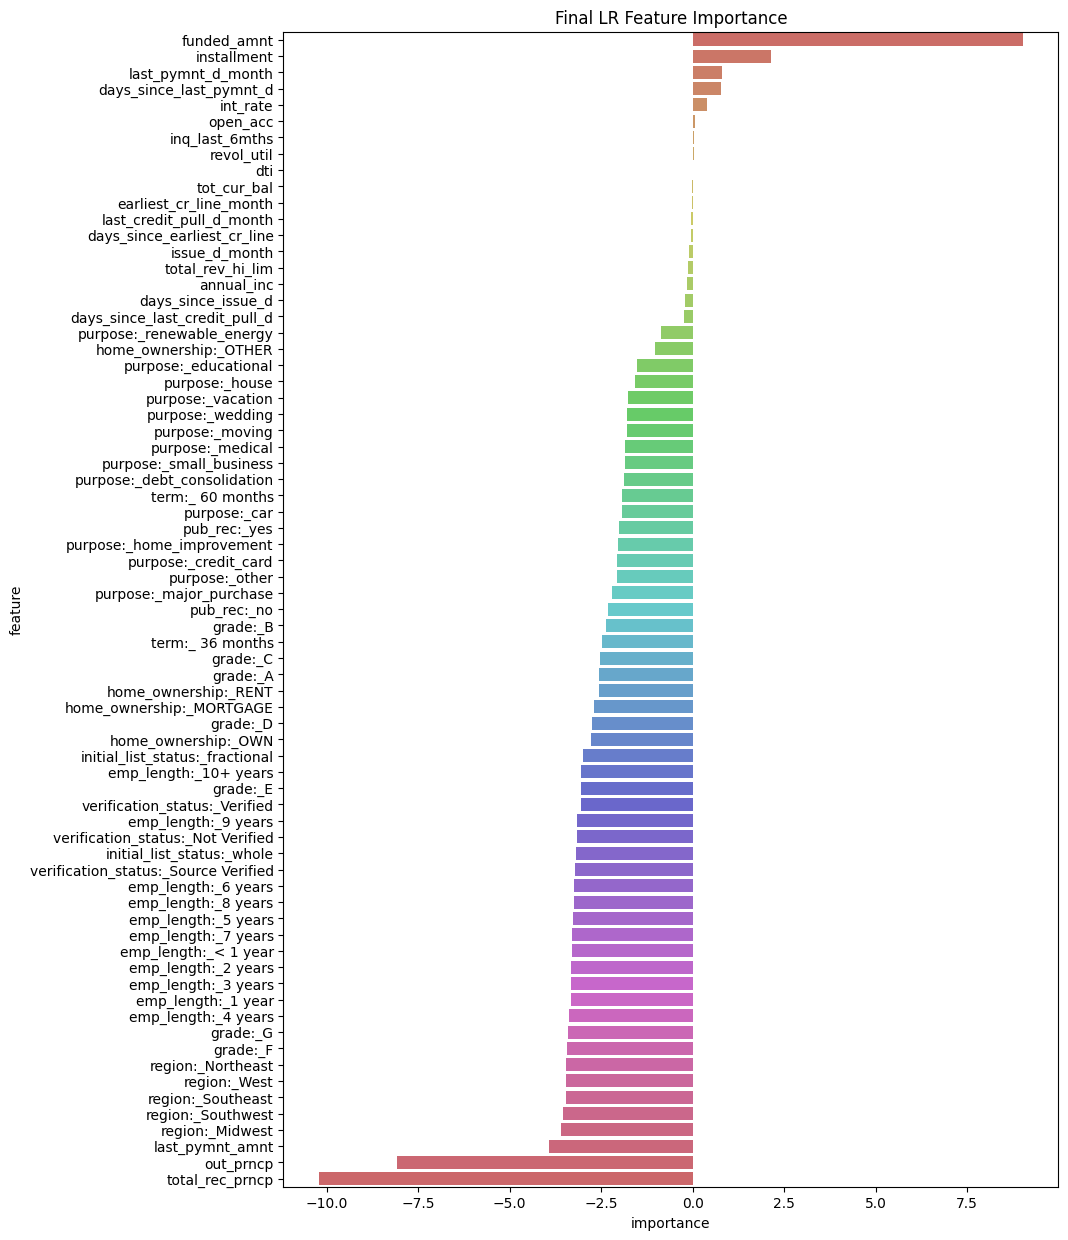

In [31]:
# Fit the Logistic Regression model to data so we can get the feature importances
feature_importance = pd.DataFrame({'feature': X_train_enc.columns, 'importance': lr_tuned2.coef_[0]})

# Sort the DataFrame by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 15))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='hls')
plt.title('Final LR Feature Importance')
plt.show()

#### Logistic Regression Feature Importance Conclusion

The feature importance in logistic regression indicates how much each feature contributes to the decision of the model. The larger the absolute value of the coefficient, the more important the feature is.

Here's the top most important features in our logistic regression model:

- `funded_amnt`: This feature has the highest positive coefficient (9.034110), indicating that as the funded amount increases, the loan is more likely to be a bad loan (positive label).

- `installment`: This feature has a positive coefficient (2.131871), indicating that as the installment amount increases, the loan is more likely to be a bad loan.

- `last_pymnt_d_month`: This feature has a positive coefficient (0.805024), indicating that as the last payment date (in terms of month) increases, the loan is more likely to be a bad loan.

- `region:_Midwest`: This feature has a negative coefficient (-3.597730), indicating that if the loan is from the Midwest region, it is more likely to be a good loan (negative label).

- `last_pymnt_amnt`: This feature has a negative coefficient (-3.917369), indicating that as the last payment amount increases, the loan is more likely to be a good loan.

- `out_prncp`: This feature has a large negative coefficient (-8.075476), indicating that as the outstanding principal increases, the loan is more likely to be a good loan.

- `total_rec_prncp`: This feature has the largest negative coefficient (-10.218261), indicating that as the total received principal increases, the loan is more likely to be a good loan.

### Other Models 

In [32]:
# Define function to evaluate models using various metrics
def evaluate_models(models, X_train, y_train, X_test, y_test, threshold):
    """
    This function evaluates the performance of a list of models using various metrics.
    
    Parameters:
    models: A list of machine learning models to be evaluated.
    X_train: The training data.
    y_train: The labels for the training data.
    X_test: The testing data.
    y_test: The labels for the testing data.
    threshold: The threshold for classifying the output into different classes.
    
    Returns:
    A DataFrame with the evaluation metrics for each model.
    """
    # Initialize an empty DataFrame to store the evaluation metrics
    df_eval = pd.DataFrame()

    # Iterate over the list of models
    for model in models:
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Predict the labels for the training and testing data
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        # Predict the probabilities of the positive class for the training and testing data
        train_pred_proba = model.predict_proba(X_train)[:, 1]  
        test_pred_proba = model.predict_proba(X_test)[:, 1]

        # Compute the ROC AUC scores for the training and testing data
        train_auc = roc_auc_score(y_train, train_pred_proba)
        test_auc = roc_auc_score(y_test, test_pred_proba)

        # Compute the recall scores for the training and testing data
        train_recall = recall_score(y_train, train_pred_proba > threshold)
        test_recall = recall_score(y_test, test_pred_proba > threshold)

        # Compute the precision scores for the training and testing data
        train_precision = precision_score(y_train, train_pred_proba > threshold)
        test_precision = precision_score(y_test, test_pred_proba > threshold)

        # Compute the F1 scores for the training and testing data
        train_f1 = f1_score(y_train, train_pred_proba > threshold)
        test_f1 = f1_score(y_test, test_pred_proba > threshold)

        # Perform Stratified K-Fold Cross Validation and compute the ROC AUC score
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1103)
        cv_score = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')

        # Create a dictionary with the evaluation metrics
        scoredict = {
            'Model': model.__class__.__name__, 
            'AUC_train': train_auc, 
            'AUC_test': test_auc,
            'Recall_train': train_recall,
            'Recall_test': test_recall,
            'Precision_train': train_precision,
            'Precision_test': test_precision,
            'F1_train': train_f1, 
            'F1_test': test_f1,
            'CrossVal_AUC': cv_score.mean()
        }

        # Append the dictionary to the DataFrame
        df_eval = df_eval.append(scoredict, ignore_index=True)

    # Return the DataFrame
    return df_eval

In [34]:
def evaluate_models(models, X_train, y_train, X_test, y_test, threshold):
    """
    This function evaluates the performance of a list of models using various metrics.
    
    Parameters:
    models: A list of machine learning models to be evaluated.
    X_train: The training data.
    y_train: The labels for the training data.
    X_test: The testing data.
    y_test: The labels for the testing data.
    threshold: The threshold for classifying the output into different classes.
    
    Returns:
    A DataFrame with the evaluation metrics for each model.
    """
    # Initialize an list to store the evaluation metrics
    eval_list = []

    # Iterate over the list of models
    for model in models:
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Predict the labels for the training and testing data
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        # Predict the probabilities of the positive class for the training and testing data
        train_pred_proba = model.predict_proba(X_train)[:, 1]  
        test_pred_proba = model.predict_proba(X_test)[:, 1]

        # Compute the ROC AUC scores for the training and testing data
        train_auc = roc_auc_score(y_train, train_pred_proba)
        test_auc = roc_auc_score(y_test, test_pred_proba)

        # Compute the recall scores for the training and testing data
        train_recall = recall_score(y_train, train_pred_proba > threshold)
        test_recall = recall_score(y_test, test_pred_proba > threshold)

        # Compute the precision scores for the training and testing data
        train_precision = precision_score(y_train, train_pred_proba > threshold)
        test_precision = precision_score(y_test, test_pred_proba > threshold)

        # Compute the F1 scores for the training and testing data
        train_f1 = f1_score(y_train, train_pred_proba > threshold)
        test_f1 = f1_score(y_test, test_pred_proba > threshold)

        # Perform Stratified K-Fold Cross Validation and compute the ROC AUC score
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1103)
        cv_score = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')

        # Create a dictionary with the evaluation metrics
        scoredict = {
            'Model': model.__class__.__name__, 
            'AUC_train': train_auc, 
            'AUC_test': test_auc,
            'Recall_train': train_recall,
            'Recall_test': test_recall,
            'Precision_train': train_precision,
            'Precision_test': test_precision,
            'F1_train': train_f1, 
            'F1_test': test_f1,
            'CrossVal_AUC': cv_score.mean()
        }

        # Append the dictionary to the list
        eval_list.append(scoredict)

    # Convert the list to a DataFrame
    df_eval = pd.DataFrame(eval_list)

    # Return the DataFrame
    return df_eval

In [35]:
# Instantiate the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=1103)

# Instantiate the Random Forest Classifier
rf = RandomForestClassifier(random_state=1103)

# Instantiate the Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=1103)

# make a list of models
models = [dt, rf, gb]

# Evaluate the models using the training data, testing data, and a threshold of 0.4
evaluate_models(models, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.4)

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,DecisionTreeClassifier,1.00000,0.500000,1.000000,1.000000,1.00000,0.112256,1.000000,0.201852,0.989923
1,RandomForestClassifier,1.00000,0.388409,1.000000,0.636948,1.00000,0.093272,1.000000,0.162716,0.999317
2,GradientBoostingClassifier,0.99664,0.528294,0.977856,1.000000,0.99554,0.112256,0.986619,0.201852,0.996671


Gradient boosting perform better than the other 2 models we've tried, even though it's stil overfitting and not as good as the base Logistic Regression model. Let's try to tune the model.

#### Hyperparameter Tuning Gradient Boosing model

In [37]:
# Define parameters of Gradien Boosting Classifier to tune
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_leaf_nodes': [4, 8, 12, 16]
}

# Initialize the RandomizedSearchCV object with 5-fold cross-validation
ransearch = RandomizedSearchCV(gb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
ransearch.fit(X_train_ovr, y_train_ovr)

# Get the best parameters and the best score
best_params = ransearch.best_params_


KeyboardInterrupt: 

In [ ]:
# Fit the tuned Gradient Boosting Classifier to the data
gb_tuned = GradientBoostingClassifier(**best_params, random_state=1103)

# Evaluate the tuned Gradient Boosting Classifier
evaluate_model(gb_tuned, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.4)

# Plot the ROC curve for the tuned Gradient Boosting Classifier
plot_roc_curve(gb_tuned, X_train_ovr, y_train_ovr, X_test_enc, y_test)

In [ ]:
# Define a dictionary with the hyperparameters for the Decision Tree model
param_dict = {
    'max_depth': 5, # The maximum depth of the tree
    'min_samples_split': 2, # The minimum number of samples required to split an internal node
    'min_samples_leaf': 1, # The minimum number of samples required to be at a leaf node
    'random_state': 1103
}

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1103)
evaluate_model(rf, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.5)

In [24]:
# # with solver = saga
# Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
# 0	LogisticRegression	0.995689	0.820767	0.922398	0.6323	0.999137	1.0	0.959235	0.774735	0.91346

# Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
# 0	LogisticRegression	0.996587	0.862138	0.942211	0.718525	0.999704	0.998849	0.970106	0.835809	0.955188

# 	Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
# 0	LogisticRegression	0.995689	0.820767	0.986789	0.6323	0.913779	1.0	0.948882	0.774735	0.91346

# Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
# 0	LogisticRegression	0.996576	0.86084	0.98384	0.71585	0.93966	0.999022	0.961243	0.834057	0.980793

# Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test	CrossVal_AUC
# 0.996587	0.862138	0.983809	     0.718525	0.939903	     0.998849	    0.961355	0.835809	0.955188